In [1]:
#!pip install geopy

In [2]:
#!pip install gpxpy

In [3]:
#!pip install folium

In [4]:
#!pip install holidays


In [5]:
import os
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
from geopy.distance import vincenty
import gpxpy.geo
import folium
from folium.plugins import HeatMap
import holidays
from time import time

from sklearn.cluster import MiniBatchKMeans, KMeans
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV



In [6]:
os.chdir('E:/Data/locale.ai')

In [7]:
df=pd.read_csv('data.csv')

In [8]:
df.head()

,id,user_id,vehicle_model_id,package_id,travel_type_id,from_area_id,to_area_id,from_city_id,to_city_id,from_date,to_date,online_booking,mobile_site_booking,booking_created,from_lat,from_long,to_lat,to_long,Car_Cancellation
0,132512,22177,28,NaN,2,83.0,448.0,NaN,NaN,1/1/2013 2:00,NaN,0,0,1/1/2013 1:39,12.924150,77.672290,12.927320,77.635750,0
1,132513,21413,12,NaN,2,1010.0,540.0,NaN,NaN,1/1/2013 9:00,NaN,0,0,1/1/2013 2:25,12.966910,77.749350,12.927680,77.626640,0
2,132514,22178,12,NaN,2,1301.0,1034.0,NaN,NaN,1/1/2013 3:30,NaN,0,0,1/1/2013 3:08,12.937222,77.626915,13.047926,77.597766,0
3,132515,13034,12,NaN,2,768.0,398.0,NaN,NaN,1/1/2013 5:45,NaN,0,0,1/1/2013 4:39,12.989990,77.553320,12.971430,77.639140,0
4,132517,22180,12,NaN,2,1365.0,849.0,NaN,NaN,1/1/2013 9:00,NaN,0,0,1/1/2013 7:53,12.845653,77.677925,12.954340,77.600720,0


In [9]:
df_copy=df.copy()

# Generalizing the Problem
One of the main issue that every ride hailing company is facing is supply demand issues. Just like Uber is overcoming it by apply surge pricing multiplier to the regions where the supply-demand ratio starts going lesser than expected. There is a very prominent solution to it:

Demand of rides vary across weekdays and time of the day across different areas. We can build a model that can predict the demand in every region given a future time, So we can move around the rides to be requested as per how the future needs would be. Analysing the factors responsible for the demand is the foremost aim of my solution, and then predicting the market potential for business for different regions so that our resources don't go to vain.





In [10]:
df.shape

(43431, 19)

In [11]:
df.isnull().sum()

id                         0
user_id                    0
vehicle_model_id           0
package_id             35881
travel_type_id             0
from_area_id              88
to_area_id              9138
from_city_id           27086
to_city_id             41843
from_date                  0
to_date                17890
online_booking             0
mobile_site_booking        0
booking_created            0
from_lat                  93
from_long                 93
to_lat                  9138
to_long                 9138
Car_Cancellation           0
dtype: int64

In [12]:
df['package_id'].value_counts()

1.0    3503
2.0    2651
6.0     502
4.0     412
3.0     375
7.0     101
5.0       6
Name: package_id, dtype: int64

In [13]:
df.describe()

,id,user_id,vehicle_model_id,package_id,travel_type_id,from_area_id,to_area_id,from_city_id,to_city_id,online_booking,mobile_site_booking,from_lat,from_long,to_lat,to_long,Car_Cancellation
count,43431.000000,43431.000000,43431.00000,7550.000000,43431.000000,43343.000000,34293.000000,16345.000000,1588.000000,43431.000000,43431.000000,43338.000000,43338.000000,34293.000000,34293.000000,43431.000000
mean,159206.473556,30739.198153,25.71723,2.030066,2.137252,714.544494,669.490917,14.915081,68.537783,0.351592,0.043241,12.982461,77.636255,13.026648,77.640595,0.072114
std,15442.386279,10996.476709,26.79825,1.461756,0.437712,419.883553,400.638225,1.165306,49.880732,0.477473,0.203402,0.085933,0.059391,0.113487,0.064045,0.258680
min,132512.000000,16.000000,1.00000,1.000000,1.000000,2.000000,2.000000,1.000000,4.000000,0.000000,0.000000,12.776630,77.386930,12.776630,77.386930,0.000000
25%,145778.000000,24614.000000,12.00000,1.000000,2.000000,393.000000,393.000000,15.000000,32.000000,0.000000,0.000000,12.926450,77.593661,12.951850,77.582030,0.000000
50%,159248.000000,31627.000000,12.00000,2.000000,2.000000,590.000000,541.000000,15.000000,49.000000,0.000000,0.000000,12.968887,77.635750,12.982750,77.645030,0.000000
75%,172578.500000,39167.000000,24.00000,2.000000,2.000000,1089.000000,1054.000000,15.000000,108.000000,1.000000,0.000000,13.007750,77.688900,13.199560,77.706880,0.000000
max,185941.000000,48730.000000,91.00000,7.000000,3.000000,1403.000000,1403.000000,31.000000,203.000000,1.000000,1.000000,13.366072,77.786420,13.366072,77.786420,1.000000


In [14]:
df['travel_type_id'].value_counts()

2    34292
3     7550
1     1589
Name: travel_type_id, dtype: int64

In [15]:
#Checking the number of areas we have the data for
len(df['from_area_id'].unique())

599

There are 596 number of areas we need to analyse demand for, However my approach is to predict demand areawise. So, I will analyse the datapoints we have for each area id. If it won't be enough, I'll divide the city of Bangalore into grids and try to predict the demand for a region for a given time.



In [16]:
df['from_city_id'].isnull().sum()

27086

In [17]:
df['vehicle_model_id'].unique()

array([28, 12, 65, 24, 87, 54, 85, 17, 23, 36, 72, 30, 43, 86, 76,  1, 69,
       14, 89, 10, 13, 64, 90, 75, 70, 91, 39], dtype=int64)

In [18]:
df.dtypes

id                       int64
user_id                  int64
vehicle_model_id         int64
package_id             float64
travel_type_id           int64
from_area_id           float64
to_area_id             float64
from_city_id           float64
to_city_id             float64
from_date               object
to_date                 object
online_booking           int64
mobile_site_booking      int64
booking_created         object
from_lat               float64
from_long              float64
to_lat                 float64
to_long                float64
Car_Cancellation         int64
dtype: object

# Cleaning and imputing the data
Here, we are mainly focussing on supply and demand including the regions themselves, So those few 88+93 missing values(['from_area_id', 'from_lat', 'from_long'] i'll drop here only.

In [19]:
#dropping unnecessary missingvalues
df=df.dropna(subset=['from_area_id','from_lat','from_long'])
df['No of Requests'] = 1

In [20]:
#converting timestamp to proper datatypes
df['from_date']=pd.to_datetime(df['from_date'])
df['to_date']=pd.to_datetime(df['to_date'])

In [21]:
df['date']=df['from_date']
df.set_index('date',inplace=True)

In [22]:
df2=df

In [23]:
#adding features which will might be very relevant for our Analysis
df['from_hour']=df['from_date'].dt.hour
df['from_weekday']=df['from_date'].dt.date.apply(lambda x: calendar.day_name[x.weekday()])
df['from_month']=df['from_date'].dt.month


In [24]:
df.isnull().sum()

id                         0
user_id                    0
vehicle_model_id           0
package_id             35788
travel_type_id             0
from_area_id               0
to_area_id              9045
from_city_id           27086
to_city_id             41843
from_date                  0
to_date                17887
online_booking             0
mobile_site_booking        0
booking_created            0
from_lat                   0
from_long                  0
to_lat                  9045
to_long                 9045
Car_Cancellation           0
No of Requests             0
from_hour                  0
from_weekday               0
from_month                 0
dtype: int64

In [25]:
df.head()

,id,user_id,vehicle_model_id,package_id,travel_type_id,from_area_id,to_area_id,from_city_id,to_city_id,from_date,...,booking_created,from_lat,from_long,to_lat,to_long,Car_Cancellation,No of Requests,from_hour,from_weekday,from_month
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01 02:00:00,132512,22177,28,NaN,2,83.0,448.0,NaN,NaN,2013-01-01 02:00:00,...,1/1/2013 1:39,12.924150,77.672290,12.927320,77.635750,0,1,2,Tuesday,1
2013-01-01 09:00:00,132513,21413,12,NaN,2,1010.0,540.0,NaN,NaN,2013-01-01 09:00:00,...,1/1/2013 2:25,12.966910,77.749350,12.927680,77.626640,0,1,9,Tuesday,1
2013-01-01 03:30:00,132514,22178,12,NaN,2,1301.0,1034.0,NaN,NaN,2013-01-01 03:30:00,...,1/1/2013 3:08,12.937222,77.626915,13.047926,77.597766,0,1,3,Tuesday,1
2013-01-01 05:45:00,132515,13034,12,NaN,2,768.0,398.0,NaN,NaN,2013-01-01 05:45:00,...,1/1/2013 4:39,12.989990,77.553320,12.971430,77.639140,0,1,5,Tuesday,1
2013-01-01 09:00:00,132517,22180,12,NaN,2,1365.0,849.0,NaN,NaN,2013-01-01 09:00:00,...,1/1/2013 7:53,12.845653,77.677925,12.954340,77.600720,0,1,9,Tuesday,1


# Analysing Supply-Demand Over Weekdays

Text(0.5,1,'Average Supply Demand Analysis per the day of Week')

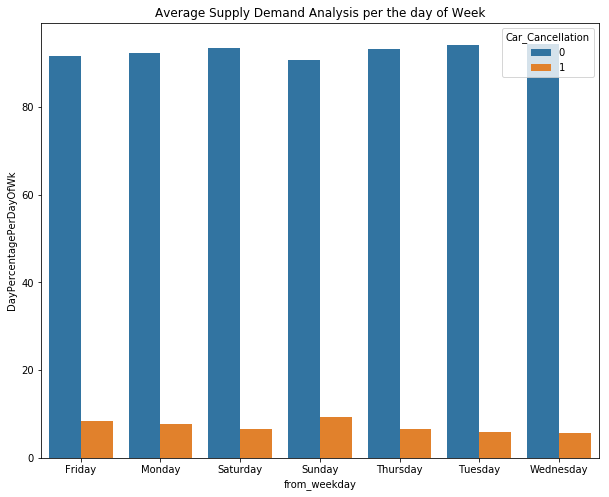

In [26]:
dfGrp = df.groupby(by = ['from_weekday', 'Car_Cancellation'])['No of Requests'].count().reset_index()


reqPrcntageList = list()
for x in dfGrp.index:
    #reqPrcntageList.append(sum(dfGrp['No of Requests'].loc[dfGrp['Request Date'] == dfGrp.loc[x, 'Request Date']]))
    reqPrcntageList.append(round(dfGrp.loc[x, 'No of Requests'] * 100 /  sum(dfGrp['No of Requests'].loc[dfGrp['from_weekday'] == dfGrp.loc[x, 'from_weekday']]), 2))

dfGrp['DayPercentagePerDayOfWk'] = reqPrcntageList
plt.figure(figsize=(10,8))
sns.barplot(x = 'from_weekday', y = 'DayPercentagePerDayOfWk', hue = 'Car_Cancellation', data = dfGrp)
plt.title('Average Supply Demand Analysis per the day of Week')

Cancellation rate is not varying much across weekdays.
Sunday has the least supply-demand gap, which is evident because that is a weekend.
Although Surprisingly, Saturday is a weekend too but the Supply-Demand gap is quite high on that day. 

This does not mean that weekdays is a bad predictor, it works different for different locations. for example, It industry area will have less cab bookings on saturday, but the airport may have more bookings due to low flight rates. It depends, we'll see.


# Analysing Supply-Demand over the Month of an Year

Text(0.5,1,'Average Supply Demand Analysis per the month of the Year')

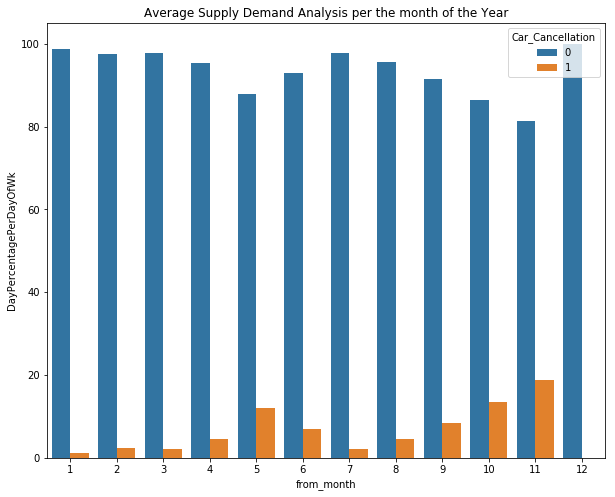

In [27]:
dfGrp = df.groupby(by = ['from_month', 'Car_Cancellation'])['No of Requests'].count().reset_index()


reqPrcntageList = list()
for x in dfGrp.index:
    #reqPrcntageList.append(sum(dfGrp['No of Requests'].loc[dfGrp['Request Date'] == dfGrp.loc[x, 'Request Date']]))
    reqPrcntageList.append(round(dfGrp.loc[x, 'No of Requests'] * 100 /  sum(dfGrp['No of Requests'].loc[dfGrp['from_month'] == dfGrp.loc[x, 'from_month']]), 2))

dfGrp['DayPercentagePerDayOfWk'] = reqPrcntageList
plt.figure(figsize=(10,8))
sns.barplot(x = 'from_month', y = 'DayPercentagePerDayOfWk', hue = 'Car_Cancellation', data = dfGrp)
plt.title('Average Supply Demand Analysis per the month of the Year')

Very evident the cancellation rate variation is across months, might be because of some months do have abundance of public holdiays and demand will vary for sure because of that. We'll add a 'holiday' feature too.

In [28]:
#adding A Holiday feature in the dataframe
ind_holidays=holidays.India()
for ptr in holidays.India(years = 2013).items(): 
    print(ptr) 

df['Holiday']=df['from_date'].isin(ind_holidays)

(datetime.date(2013, 1, 1), 'New Year')
(datetime.date(2013, 1, 14), 'Makar Sankranti / Pongal')
(datetime.date(2013, 1, 26), 'Republic Day')
(datetime.date(2013, 8, 15), 'Independence Day')
(datetime.date(2013, 10, 2), 'Gandhi Jayanti')
(datetime.date(2013, 5, 1), 'Labour Day')
(datetime.date(2013, 12, 25), 'Christmas')


# Analysing Supply-Demand of every Hour of the day

Text(0.5,1,'Average Supply Demand Analysis per the hour of day')

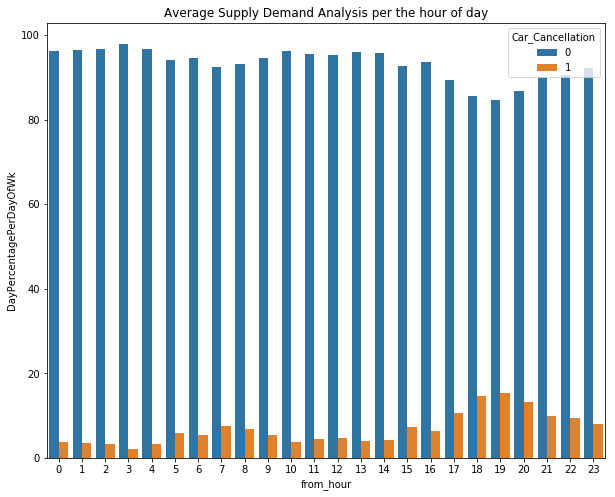

In [29]:
dfGrp = df.groupby(by = ['from_hour', 'Car_Cancellation'])['No of Requests'].count().reset_index()


reqPrcntageList = list()
for x in dfGrp.index:
    #reqPrcntageList.append(sum(dfGrp['No of Requests'].loc[dfGrp['Request Date'] == dfGrp.loc[x, 'Request Date']]))
    reqPrcntageList.append(round(dfGrp.loc[x, 'No of Requests'] * 100 /  sum(dfGrp['No of Requests'].loc[dfGrp['from_hour'] == dfGrp.loc[x, 'from_hour']]), 2))

dfGrp['DayPercentagePerDayOfWk'] = reqPrcntageList
plt.figure(figsize=(10,8))
sns.barplot(x = 'from_hour', y = 'DayPercentagePerDayOfWk', hue = 'Car_Cancellation', data = dfGrp)
plt.title('Average Supply Demand Analysis per the hour of day')

The Cancellation rate trend is very clear as we can see. After 4PM, the demand is highly increased and so the cancellation rate. This is mainly because of busy working hours. In a city like Bangalore, working professionals are abundant, and they will be a crucial deciding factor for demand in the IT sector location.

In [30]:
#fig, ax = plt.subplots(ncols=1, nrows=1,figsize=(12,10))
#plt.ylim(77.2, 78)
#plt.xlim(12.5,13.5)
#ax.scatter(df['from_long'],df['from_lat'], s=0.01, alpha=1)

### Analysing overall Density of requests and pickups

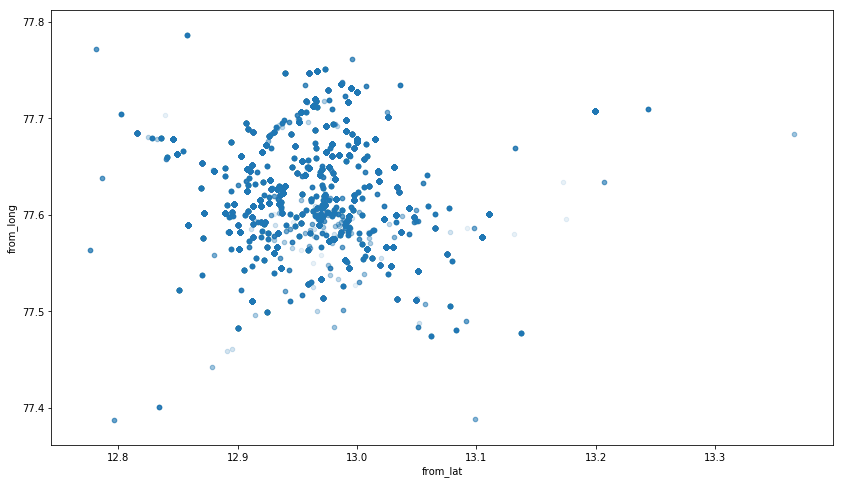

In [31]:
df.plot(kind="scatter", x="from_lat", y="from_long", alpha=0.1,figsize=(14,8))
plt.savefig('map1.png')

### Cancellation rate across regions in the City

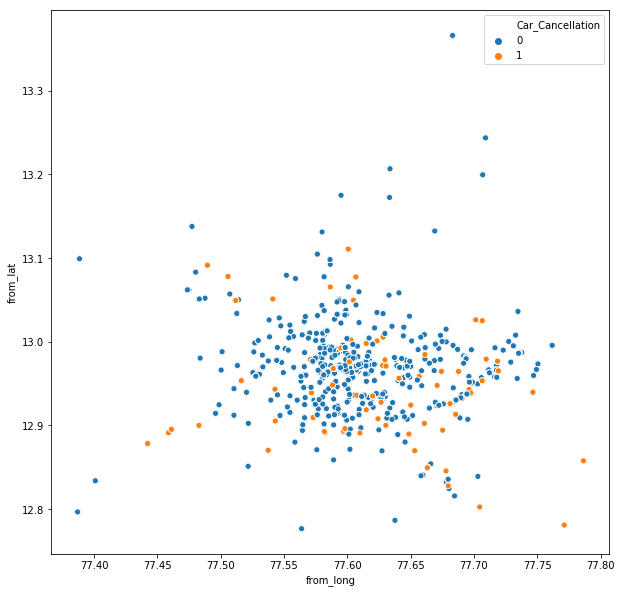

In [32]:
plt.figure(figsize=(10,10))
sns.scatterplot(x='from_long',y='from_lat',hue='Car_Cancellation',data=df)

The Orange Points shows the regions with the highest cancellation rate, there should be more cab spots added in these regions of the city






::

# Note: 
The dataset given contains 596 area_ids, and only 44,000 entries are given. This is pretty that there are very small amount of pickups corresponding to each region, which will be not enough to train the model for each region.

So, we'll split the city into clusters to give driver more accurate preditions.

# Splitting City into clusters

In [33]:
coords = df[['from_lat', 'from_long']].values
neighbours=[]

def find_min_distance(cluster_centers, cluster_len):
    nice_points = 0
    wrong_points = 0
    less2 = []
    more2 = []
    min_dist=1000
    for i in range(0, cluster_len):
        nice_points = 0
        wrong_points = 0
        for j in range(0, cluster_len):
            if j!=i:
                distance = gpxpy.geo.haversine_distance(cluster_centers[i][0], cluster_centers[i][1],cluster_centers[j][0], cluster_centers[j][1])
                min_dist = min(min_dist,distance/(1.60934*1000))
                if (distance/(1.60934*1000)) <= 2:
                    nice_points +=1
                else:
                    wrong_points += 1
        less2.append(nice_points)
        more2.append(wrong_points)
    neighbours.append(less2)
    print ("On choosing a cluster size of ",cluster_len,"\nMin inter-cluster distance = ",min_dist,"\n---")

def find_clusters(increment):
    kmeans = MiniBatchKMeans(n_clusters=increment, batch_size=10000,random_state=42).fit(coords)
    df['pickup_cluster'] = kmeans.predict(df[['from_lat', 'from_long']])
    cluster_centers = kmeans.cluster_centers_
    cluster_len = len(cluster_centers)
    return cluster_centers, cluster_len

for increment in range(10, 100, 10):
    cluster_centers, cluster_len = find_clusters(increment)
    find_min_distance(cluster_centers, cluster_len)

On choosing a cluster size of  10 
Min inter-cluster distance =  3.385674208351904 
---
On choosing a cluster size of  20 
Min inter-cluster distance =  1.834108540003719 
---
On choosing a cluster size of  30 
Min inter-cluster distance =  1.5403799591717773 
---
On choosing a cluster size of  40 
Min inter-cluster distance =  1.4177861053133842 
---
On choosing a cluster size of  50 
Min inter-cluster distance =  1.1301194290970447 
---
On choosing a cluster size of  60 
Min inter-cluster distance =  1.0279701202935072 
---
On choosing a cluster size of  70 
Min inter-cluster distance =  0.7670221764084679 
---
On choosing a cluster size of  80 
Min inter-cluster distance =  0.8105327710526953 
---
On choosing a cluster size of  90 
Min inter-cluster distance =  0.6253339871697718 
---


We will choose the cluster distribution with minimum inter-cluster distance, and plus we don't want the number of clusters too large.

Here, cluster size of 70 looks good.

In [34]:
kmeans = MiniBatchKMeans(n_clusters=70, batch_size=10000,random_state=0).fit(coords)
df['pickup_cluster'] = kmeans.predict(df[['from_lat', 'from_long']])

In [35]:
#visualizing the cluster centers in the city

cluster_centers = kmeans.cluster_centers_
cluster_len = len(cluster_centers)
map_osm = folium.Map(location=[13.1, 77.6], tiles='Stamen Toner')
for i in range(cluster_len):
    folium.Marker(list((cluster_centers[i][0],cluster_centers[i][1])), popup=(str(cluster_centers[i][0])+str(cluster_centers[i][1]))).add_to(map_osm)
map_osm

# Simplifying Our dataset




In [36]:
#Grouping the number of cabs being requested in each cluster on different times
dfgrp=df.groupby(['pickup_cluster','from_hour','from_weekday','from_month'])['No of Requests'].count().reset_index()
dfgrp.head()
#sns.lineplot(x=dfgrp.index , y='No of Requests', data=dfgrp[dfgrp.pickup_cluster==0])

,pickup_cluster,from_hour,from_weekday,from_month,No of Requests
0,0,1,Tuesday,5,1
1,0,1,Tuesday,10,1
2,0,1,Wednesday,10,1
3,0,2,Monday,6,1
4,0,2,Monday,8,1


In [37]:
#Creating a date range from 1st january 2013 to 25th november 2013 for each hour.
date_rng = pd.date_range(start='1/1/2013', end='25/11/2013', freq='H')
date_df = pd.DataFrame(date_rng, columns=['date'])
date_df.head()

,date
0,2013-01-01 00:00:00
1,2013-01-01 01:00:00
2,2013-01-01 02:00:00
3,2013-01-01 03:00:00
4,2013-01-01 04:00:00


In [38]:
date_df['from_hour']=date_df['date'].dt.hour
date_df['from_weekday']=date_df['date'].dt.date.apply(lambda x: calendar.day_name[x.weekday()])
date_df['from_month']=date_df['date'].dt.month
date_df.head()

,date,from_hour,from_weekday,from_month
0,2013-01-01 00:00:00,0,Tuesday,1
1,2013-01-01 01:00:00,1,Tuesday,1
2,2013-01-01 02:00:00,2,Tuesday,1
3,2013-01-01 03:00:00,3,Tuesday,1
4,2013-01-01 04:00:00,4,Tuesday,1


::

We don't yet have the data which tells "there are 0 number of requests in region x at a time y". because, we only have the data which tells about the time where cabs have been requested. We also need the information about when there is no demand in that region for an hour.

So, we'll add the all possible combinations of time for each cluster in the dataframe. Enhanced infomation.

In [39]:
#adding the rows for each hour per cluster when there is no cab request.

names = ['pickup_cluster', 'from_hour', 'from_weekday','from_month']

mind = pd.MultiIndex.from_product([dfgrp['pickup_cluster'].unique(), dfgrp['from_hour'].unique(), dfgrp['from_weekday'].unique(),dfgrp['from_month'].unique()], names=names)

dfgrp=dfgrp.set_index(names).reindex(mind, fill_value=0).reset_index()

dfgrp.head()

,pickup_cluster,from_hour,from_weekday,from_month,No of Requests
0,0,1,Tuesday,5,1
1,0,1,Tuesday,10,1
2,0,1,Tuesday,6,0
3,0,1,Tuesday,8,0
4,0,1,Tuesday,2,0


In [40]:
#adding the timestamp column in the dataframe
df2=pd.merge(dfgrp, date_df, on=['from_hour','from_weekday','from_month'], how='left')


In [41]:
df2=df2.dropna()
#df2=df2.sort_values(by='date',ascending=True)
#df2

In [42]:
#sorting the dataframe by time
df2=df2.groupby('pickup_cluster').apply(lambda x: x.sort_values('date'))
df2.head()


pickup_cluster  from_hour from_weekday  from_month  \
pickup_cluster                                                            
0              7734               0          0      Tuesday           1   
               29                 0          1      Tuesday           1   
               364                0          2      Tuesday           1   
               699                0          3      Tuesday           1   
               1034               0          4      Tuesday           1   

                     No of Requests                date  
pickup_cluster                                           
0              7734               0 2013-01-01 00:00:00  
               29                 0 2013-01-01 01:00:00  
               364                0 2013-01-01 02:00:00  
               699                0 2013-01-01 03:00:00  
               1034               0 2013-01-01 04:00:00

# Feature Engineering

As this is a time series data, we will add features which tells us about the trend which is being followed by the demand in each cluster. So, we will add 5 features:

-t1: number of requests one hour before in that region.
-t2: number of requests two hours before in that region.
-t3: number of requests three hours before in that region.
-t4: number of requests four hours before in that region.
-t5: number of requests five hours before in that region.


In [43]:
t1=[0,0,0,0,0]
t2=[0,0,0,0,0]
t3=[0,0,0,0,0]
t4=[0,0,0,0,0]
t5=[0,0,0,0,0]

r=list(df2['No of Requests'])

for i in range(5,551110):
    t1.append(r[i-1])
    t2.append(r[i-2])
    t3.append(r[i-3])
    t4.append(r[i-4])
    t5.append(r[i-5])
    
    

In [44]:
len(df2.loc[1,'pickup_cluster'])

7873

In [45]:
#adding the cluster center's location feature.
lat = []
long = []
for i in range(0,70):
    for j in range(0,7873):
        lat.append([cluster_centers[i][0]])
        long.append([cluster_centers[i][1]])

latitude=[]
longitude=[]
for i in range(0,551110):
    latitude.append(lat[i][0])
    longitude.append(long[i][0])
    

In [46]:
df2['latitude']=latitude
df2['longitude']=longitude
df2['t1']=t1
df2['t2']=t2
df2['t3']=t3
df2['t4']=t4
df2['t5']=t5
df2.head()

pickup_cluster  from_hour from_weekday  from_month  \
pickup_cluster                                                            
0              7734               0          0      Tuesday           1   
               29                 0          1      Tuesday           1   
               364                0          2      Tuesday           1   
               699                0          3      Tuesday           1   
               1034               0          4      Tuesday           1   

                     No of Requests                date   latitude  longitude  \
pickup_cluster                                                                  
0              7734               0 2013-01-01 00:00:00  12.992206  77.716594   
               29                 0 2013-01-01 01:00:00  12.992206  77.716594   
               364                0 2013-01-01 02:00:00  12.992206  77.716594   
               699                0 2013-01-01 03:00:00  12.992206  77.716594   
               1034               0 2013-01-01 04:00:00  12.992206  77.716594   

                     t1  t2  t3  t4  t5  
pickup_cluster                           
0              7734   0   0   0   0   0  
               29     0   0   0   0   0  
               364    0   0   0   0   0  
               699    0   0   0   0   0  
               1034   0   0   0   0   0

In [47]:
#adding the holiday feature
df2['Holiday']=df2['date'].isin(ind_holidays)

In [48]:
# Making the final cleaned data frame with the relevant features extracted
df2_cleaned=df2[['Holiday','from_hour','from_weekday','from_month','No of Requests','latitude','longitude','t1','t2','t3','t4','t5']]
df2_cleaned.head()


Holiday  from_hour from_weekday  from_month  \
pickup_cluster                                                     
0              7734    False          0      Tuesday           1   
               29      False          1      Tuesday           1   
               364     False          2      Tuesday           1   
               699     False          3      Tuesday           1   
               1034    False          4      Tuesday           1   

                     No of Requests   latitude  longitude  t1  t2  t3  t4  t5  
pickup_cluster                                                                 
0              7734               0  12.992206  77.716594   0   0   0   0   0  
               29                 0  12.992206  77.716594   0   0   0   0   0  
               364                0  12.992206  77.716594   0   0   0   0   0  
               699                0  12.992206  77.716594   0   0   0   0   0  
               1034               0  12.992206  77.716594   0   0   0   0   0

In [49]:
# splitting dependent and the independent variables
X=df2_cleaned[['Holiday','from_hour','from_weekday','from_month','latitude','longitude','t1','t2','t3','t4','t5']]
Y=df2_cleaned[['No of Requests']]

In [50]:
#One-hot encoding the weekday feature
temp = pd.get_dummies(X['from_weekday'], prefix = i)
X = X.join(temp)

In [51]:
X=X.drop('from_weekday',axis=1)

In [52]:
# train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

# Using Xgboost Regressor

In [53]:
#RandomizedSearchCV for Hyperparameter tuning
#Tune the parameters by running this cell and update the parameters in the next cell(where the model is defined). My laptop keeps hanging whenever i try to run RandomizedSearchCv to hypertune my models.
'''x_model = xgb.XGBRegressor()
param_dist = {"max_depth": [3, 4,5],
              "min_child_weight": [3, 4,5,6],
              "gamma":[0,0.1,0.2],
              "colsample_bytree":[0.7,0.8,0.9],
              "nthread":[3,4,5]
              }

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(x_model, param_distributions=param_dist,
                                   n_iter=n_iter_search)

start = time()
random_search.fit(df_train, tsne_train_output)

print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)'''

'x_model = xgb.XGBRegressor()\nparam_dist = {"max_depth": [3, 4,5],\n              "min_child_weight": [3, 4,5,6],\n              "gamma":[0,0.1,0.2],\n              "colsample_bytree":[0.7,0.8,0.9],\n              "nthread":[3,4,5]\n              }\n\n# run randomized search\nn_iter_search = 20\nrandom_search = RandomizedSearchCV(x_model, param_distributions=param_dist,\n                                   n_iter=n_iter_search)\n\nstart = time()\nrandom_search.fit(df_train, tsne_train_output)\n\nprint("RandomizedSearchCV took %.2f seconds for %d candidates"\n      " parameter settings." % ((time() - start), n_iter_search))\nreport(random_search.cv_results_)'

In [56]:
# Training the Xgboost model.
x_model = xgb.XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=5,
 gamma=0.1,
 subsample=0.8,
 reg_alpha=200, reg_lambda=200,
 colsample_bytree=0.7,nthread=5)

x_model.fit(X_train, Y_train)



[16:23:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.7, gamma=0.1,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=5, missing=None, n_estimators=1000,
       n_jobs=1, nthread=5, objective='reg:linear', random_state=0,
       reg_alpha=200, reg_lambda=200, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.8, verbosity=1)

In [57]:
#Predicting the test values
Y_pred = x_model.predict(X_test)
xgb_test_predictions = [round(value) for value in Y_pred]
Y_pred = x_model.predict(X_train)
xgb_train_predictions = [round(value) for value in Y_pred]



In [58]:
X_test['No of Requests']= xgb_test_predictions 


C:\Users\Aditya\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


# Visualizing the demand for each region

In [59]:
# generating a base map of Bengaluru.
def generateBaseMap(default_location=[13.1, 77.6], default_zoom_start=10):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

In [60]:
# Demand HeatMap for 6PM across regions in the city of Bengaluru
from folium.plugins import HeatMap
map_data = X_test[X_test.from_hour==18]
base_map = generateBaseMap()
HeatMap(data=map_data[['latitude','longitude','No of Requests']].groupby(['latitude', 'longitude']).sum().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(base_map)
base_map



# Visualizing the demand in the city over-time.

In [61]:
#Visualizing the predicted demand

df_hour_list=[]

for hour in X_test.from_hour.sort_values().unique():
    df_hour_list.append(X_test.loc[X_test.from_hour == hour, ['latitude', 'longitude', 'No of Requests']].groupby(['latitude', 'longitude']).sum().reset_index().values.tolist())

from folium.plugins import HeatMapWithTime
base_map = generateBaseMap(default_zoom_start=9)
HeatMapWithTime(df_hour_list, radius=5, gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}, min_opacity=0.6, max_opacity=1, use_local_extrema=True).add_to(base_map)
base_map


In [62]:
# Visualizing the actual raw dataset demand

df_hour_list=[]

for hour in df.from_hour.sort_values().unique():
    df_hour_list.append(df.loc[df.from_hour == hour, ['from_lat', 'from_long', 'No of Requests']].groupby(['from_lat', 'from_long']).sum().reset_index().values.tolist())

from folium.plugins import HeatMapWithTime
base_map = generateBaseMap(default_zoom_start=9)
HeatMapWithTime(df_hour_list, radius=5, gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}, min_opacity=0.3, max_opacity=1, use_local_extrema=True).add_to(base_map)
base_map

# Visualizing Car Cancellation over time


In [ ]:
df_hour_list=[]

for hour in df.from_hour.sort_values().unique():
    df_hour_list.append(df.loc[df.from_hour == hour, ['from_lat', 'from_long', 'Car_Cancellation']].groupby(['from_lat', 'from_long']).sum().reset_index().values.tolist())

from folium.plugins import HeatMapWithTime
base_map = generateBaseMap(default_zoom_start=9)
HeatMapWithTime(df_hour_list, radius=5, gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}, min_opacity=0.3, max_opacity=1, use_local_extrema=True).add_to(base_map)
base_map

# Conclusion:

### (i) The demand trends are changing differently in each region every hour also depending on the weekday. The trend also found a vary slightly for different months but it is quite similar.

### (ii) There are whole lot of car cancellation during midnight 3-5AM around the center, southern and western region of the city.

### (iii) Car cancellations increases around 2PM in the center region of the city.

### (iv) Marathahalli area is constantly high on demand the whole evening, and also encountering quite a lot of cancellations.

### (v) Airport is never idle on ride requests.


## To Calculate Surge Multiplier: 

##### Surge multiplier for every region is 1 unless the demand overshadows the supply in that area.

##### Based on the distribution of drivers across the city in real-time and the predicted demand, we can manipulate the positions of the drivers for the upcoming hour to minimize cancellations.

##### In the case, when the drivers could not be allocated the regions because of high demand all across the city, we will enable the surge multiplier like:-  Surge multiplier = (no. of requests in that region / no. of rides available around that region) to balance out the demand-supply gap in each region.

By this, we solved both, the Cancellation issue and the supply-demand gap issue.


